## **Lectura 1: Flujo en redes como programas lineales** 

## Ruta mas corta. 

El problema de la ruta mas corta consiste en encontrar la ruta de menor costo entre un par de nodos en una red.

![](../Images/ruta_mas_corta_google.png)

#### Ejemplo Motivador:

Supongamos que eres un viajero que busca ir de la ciudad A a la ciudad E utilizando la red de carreteras existente. Dada la siguiente red con las distancias entre ciudades, encuentra la ruta más corta entre la ciudad A y la ciudad E.

```
A - B: 5 km
A - C: 7 km
B - C: 3 km
B - D: 4 km
C - D: 2 km
C - E: 6 km
D - E: 5 km
```



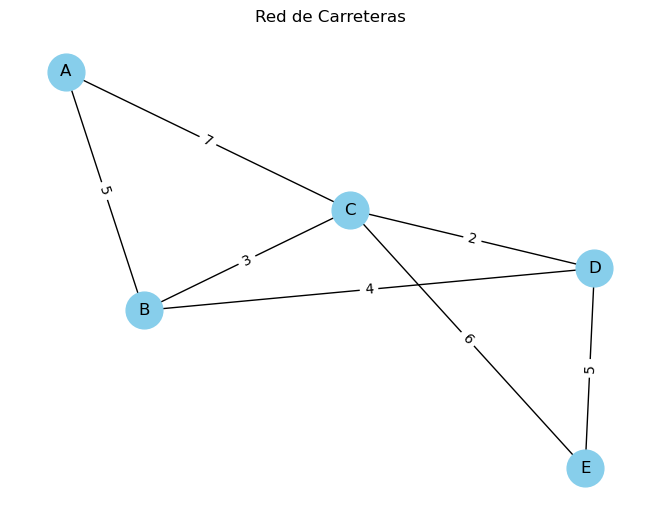

In [1]:
import networkx as nx
import matplotlib.pyplot as plt


# Datos
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E')]
costs = {(edges[i]): c for i, c in enumerate([5, 7, 3, 4, 2, 6, 5])}

# Crear el grafo
G = nx.Graph()
for edge, cost in costs.items():
    G.add_edge(edge[0], edge[1], weight=cost)

# Dibujar la instancia
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Red de Carreteras")
plt.show()

**Formulación del problema de optimización**


- **Variables de decisión**:
   $ x_{ij} $ : 1 si el camino entre ciudad $i$ y $j$ es tomado; 0 de lo contrario.

- **Función objetivo**:
   Minimizar $ \sum_{(i,j) \in A} c_{ij} x_{ij} $, 
      donde $c_{ij}$ es la distancia entre la ciudad $i$ y $j$.

- **Restricciones**:
  1. Debe salir de la ciudad A: $ \sum_{j|(A,j) \in A} x_{Aj} = 1 $
  2. Debe llegar a la ciudad E: $ \sum_{i|(i,E) \in A} x_{iE} = 1 $
  3. Balance de flujo para las ciudades intermedias: $\sum_{j|(i,j) \in A} x_{ij} - \sum_{k|(k,i) \in A} x_{ki} = 0 , \forall i$ que no sea A o E.



**Código en Gurobi**:


In [2]:
from gurobipy import Model, GRB
m = Model()

# Variables
x = m.addVars(edges, obj=costs, vtype=GRB.BINARY, name="x")

# Restricciones
m.addConstr(x.sum('A', '*') == 1, "Salida desde A")
m.addConstr(x.sum('*', 'E') == 1, "Llegada a E")
for i in nodes:
    if i not in ['A', 'E']:
        m.addConstr(x.sum(i, '*') - x.sum('*', i) == 0, f"Balance en {i}")

# Optimización
m.optimize()

# Imprimir solución
if m.status == GRB.OPTIMAL:
    for edge in edges:
        if x[edge].x > 0.5:
            print(f"Ruta desde {edge[0]} a {edge[1]}")

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5 rows, 7 columns and 14 nonzeros
Model fingerprint: 0xa06d13ef
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
Ruta desde A a C
Ruta desde C a E


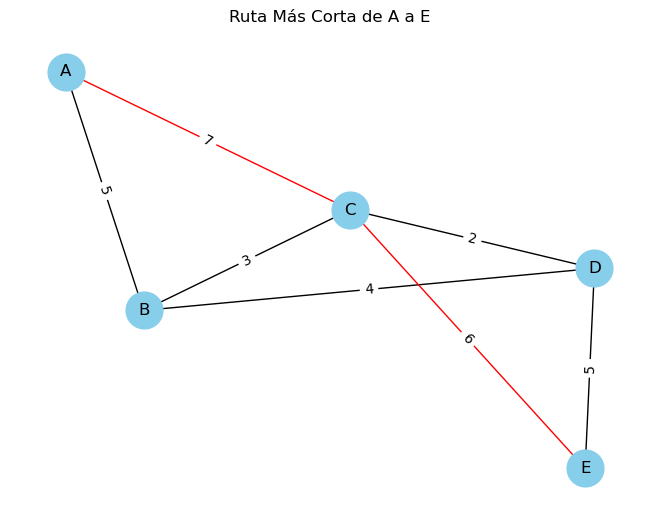

In [3]:
# Graficar la solución
edges_taken = [edge for edge in edges if x[edge].x > 0.5]

edge_colors = ['red' if edge in edges_taken else 'black' for edge in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color=edge_colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Ruta Más Corta de A a E")
plt.show()

**Ejercicio** 

Ahora intenta resolver la siguiente instancia: 

```
A -> B: 5 km

A -> C: 7 km

B -> C: 3 km

B -> D: 4 km

B -> F: 6 km

C -> D: 2 km

C -> E: 8 km

D -> E: 7 km

D -> F: 5 km

E -> G: 9 km

F -> G: 3 km

F -> H: 7 km

G -> H: 4 km

H -> I: 6 km

E -> I: 11 km
```

Cual es la ruta más corta entre A y I?

In [4]:
# Pon tu código aquí



## Versiones derivadas del problema de la ruta más corta

Supongamos que queremos ahora determinar el camino mas corto entre un nodo fuente y todos los demás nodos de la red. 

**Formulación del problema de optimización**

- **Variables de decisión**:
   $ x_{ij} \ge 0$ , fonde 1 si el camino entre ciudad $i$ y $j$ es tomado; 0 de lo contrario.

- **Función objetivo**:
    Minimizar $ \sum_{(i,j) \in A} c_{ij} x_{ij} $, 
        donde $c_{ij}$ es la distancia entre la ciudad $i$ y $j$.
- **Restricciones**:
  1. Balance de flujo para la ciudad fuente:  $\sum_{j|(i,j) \in A} x_{ij} - \sum_{k|(k,i) \in A} x_{ki} = n-1 , \forall i$ para el nodo fuente, siendo $n$ el  número de ciudades.
  2. Balance de flujo para las ciudades intermedias: $\sum_{j|(i,j) \in A} x_{ij} - \sum_{k|(k,i) \in A} x_{ki} = 0 , \forall i$ que no sea fuente.



**Ejercicio**

Supongamos que quiero tener la distancia mas corta entre varios nodos fuente y todos los demás nodos de la red de una sola vez, cuidado, los nodos que no son fuentes apenas estan conectados a uno de los nodos fuente.

In [5]:
# Pon tu código aquí

## Problema de Flujo Máximo

El problema de flujo máximo busca encontrar el mayor flujo posible que puede ser enviado de un nodo fuente a un nodo destino en una red dada.

#### Ejemplo Motivador:

Imaginemos que tenemos una red de tuberías que conecta diferentes puntos (nodos). Cada tubería (arista) tiene una capacidad de flujo determinada. El objetivo es encontrar el flujo máximo que puede ser transportado desde un punto de origen (fuente) hasta un punto final (sumidero) sin exceder las capacidades de las tuberías.

#### Formulación Matemática:

Dado un grafo $ G = (V, E)$  con un conjunto de nodos $ V $ y un conjunto de aristas $ E $. Cada arista $(i, j)$ tiene una capacidad $c_{ij}$. Buscamos el flujo $f_{ij}$ tal que:

**Variables**:
- $f_{ij}$ : Flujo en la arista $(i, j)$.

**Función Objetivo**:

Maximizar $ \sum_{j \in V} f_{sj} $ (Maximizar el flujo saliente del nodo fuente).

**Restricciones**:

1. **Conservación del Flujo** (para todos los nodos excepto la fuente y el sumidero): 

   $\sum_{j \in V} f_{ji} - \sum_{j \in V} f_{ij} = 0 $

2. **Restricción de Fuente**:
   
   $ \sum_{j \in V} f_{sj} - \sum_{j \in V} f_{js} \geq 0 $

3. **Restricción de Sumidero**:

   $ \sum_{j \in V} f_{jt} - \sum_{j \in V} f_{tj} \leq 0 $   
   
4. **Capacidad de las Aristas**: 

   $ 0 \leq f_{ij} \leq c_{ij} $ para todo $(i, j) \in E $



**Intenta plantear una formulación alternativa**

- Escribe tu modelo aquí


#### Ejemplo motivador :

Consideremos el siguiente grafo dirigido:

```
A (Fuente) -> B: 20
A -> C: 30
B -> C: 10
B -> D: 30
C -> D: 20
C -> E (Sumidero): 10
D -> E: 40
```

Queremos encontrar el flujo máximo desde A hasta E.



**Código en python**


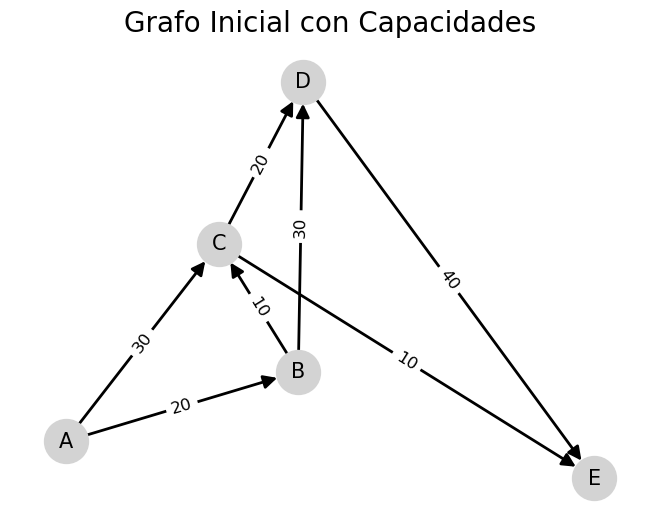

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

# Datos
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E')]
capacities = {(edges[i]): c for i, c in enumerate([20, 30, 10, 30, 20, 10, 40])}

# Crear el grafo dirigido con NetworkX
G = nx.DiGraph()
for edge, capacity in capacities.items():
    G.add_edge(edge[0], edge[1], capacity=capacity)

# Visualización con NetworkX - Grafo Inicial
pos = nx.spring_layout(G)
edge_labels = {(i, j): f"{G[i][j]['capacity']}" for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightgray', arrowsize=20, width=2, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.title("Grafo Inicial con Capacidades", size=20)
plt.show()


In [7]:
# Modelo en Gurobi
m = Model()

# Variables
flow = m.addVars(edges, ub=capacities, name="flow")

# Restricciones
for i in nodes:
    if i == 'A':  # Fuente
        m.addConstr(flow.sum(i, '*') - flow.sum('*', i) >= 0, f"Source_{i}")
    elif i == 'E':  # Sumidero
        m.addConstr(flow.sum(i, '*') - flow.sum('*', i) <= 0, f"Sink_{i}")
    else:  # Conservación del flujo
        m.addConstr(flow.sum(i, '*') - flow.sum('*', i) == 0, f"FlowConserv_{i}")

# Función objetivo
m.setObjective(flow.sum('A', '*') - flow.sum('*', 'A'), GRB.MAXIMIZE)

# Optimizar
m.optimize()



Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5 rows, 7 columns and 14 nonzeros
Model fingerprint: 0x59b4cac7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 4e+01]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 4 columns
Presolve time: 0.02s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+01   0.000000e+00   0.000000e+00      0s
       0    5.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.000000000e+01


In [8]:

# Imprimir solución
print("\nFlujos óptimos en cada arista:")
for edge, variable in flow.items():
    print(f"Flujo desde {edge[0]} hacia {edge[1]}: {variable.x}/{capacities[edge]}")


Flujos óptimos en cada arista:
Flujo desde A hacia B: 20.0/20
Flujo desde A hacia C: 30.0/30
Flujo desde B hacia C: 0.0/10
Flujo desde B hacia D: 20.0/30
Flujo desde C hacia D: 20.0/20
Flujo desde C hacia E: 10.0/10
Flujo desde D hacia E: 40.0/40


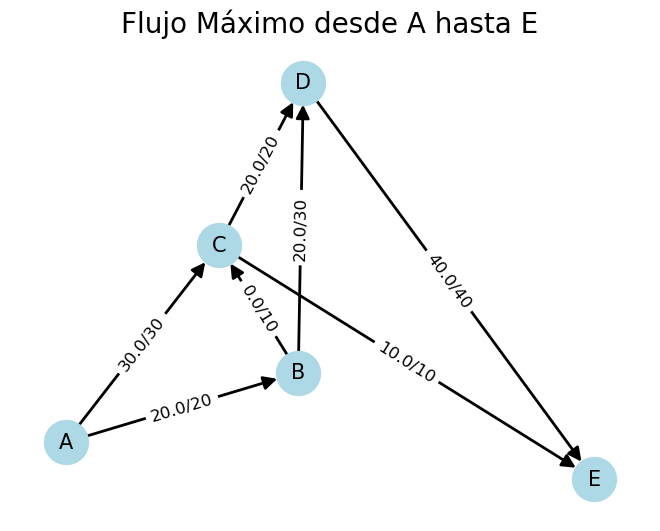

In [9]:
# Actualizar el grafo con los flujos
for edge, variable in flow.items():
    G[edge[0]][edge[1]]['flow'] = variable.x

# Visualización con NetworkX - Grafo con Flujos
edge_labels_with_flow = {(i, j): f"{G[i][j]['flow']}/{G[i][j]['capacity']}" for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', arrowsize=20, width=2, font_size=15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_with_flow, font_size=12)

plt.title("Flujo Máximo desde A hasta E", size=20)
plt.show()

## Ejercicio

**Problema de Evacuación de Emergencia**

La ciudad de Industropolis, una metrópoli próspera situada cerca de un gran río, está en grave peligro debido a la inminente ruptura de un dique cercano. Las autoridades locales han decidido llevar a cabo una evacuación masiva para garantizar la seguridad de sus habitantes. Sin embargo, la operación de evacuación es compleja debido a la estructura de las carreteras de la ciudad y a las limitaciones de capacidad.

Industropolis cuenta con 3 puntos de evacuación estratégicos a los que llamaremos E1, E2 y E3. Además, hay 3 zonas seguras fuera de la ciudad donde las personas pueden ser llevadas para su seguridad, denominadas Z1, Z2 y Z3. 

La red de carreteras entre los puntos de evacuación y las zonas seguras se puede representar como un conjunto de rutas. Cada ruta tiene una capacidad máxima, que representa el número de personas que puede ser evacuado por esa ruta en una hora. Algunas rutas conectan puntos de evacuación con zonas seguras, mientras que otras conectan diferentes puntos de evacuación entre sí, representando intersecciones o vías principales dentro de la ciudad.

Los datos de las capacidades de las rutas se detallan a continuación:

**Rutas y Capacidades:**

- $E1 \rightarrow N1$: 4000 personas/hora
- $E2 \rightarrow N1$: 3000 personas/hora
- $E2 \rightarrow N2$: 2000 personas/hora
- $E3 \rightarrow N3$: 4500 personas/hora
- $N1 \rightarrow N3$: 2500 personas/hora
- $N1 \rightarrow N4$: 3500 personas/hora
- $N2 \rightarrow N4$: 3000 personas/hora
- $N3 \rightarrow Z1$: 4000 personas/hora
- $N3 \rightarrow Z2$: 1500 personas/hora
- $N4 \rightarrow Z2$: 3000 personas/hora
- $N4 \rightarrow Z3$: 2500 personas/hora

Su tarea es determinar:

1. ¿Cuál es el número máximo de personas que pueden ser evacuadas de Industropolis en una hora?
2. ¿Qué ruta o rutas representan los cuellos de botella en esta operación de evacuación?
3. Si se tuviera la opción de aumentar la capacidad de una sola ruta en 1000 personas/hora, ¿cuál debería ser para maximizar aún más la evacuación?



**Formulación del problema**
la formulación matemática para el problema de evacuación con múltiples fuentes y sumideros es la siguiente:

### Conjuntos:
- $ E $ : Conjunto de puntos de evacuación (fuentes)
- $ Z $ : Conjunto de zonas seguras (sumideros)
- $ N $ : Conjunto de nodos intermedios
- $ R $ : Conjunto de rutas (arcos) entre nodos

### Parámetros:
- $ c_{ij} $ : Capacidad de personas por hora que pueden ser evacuadas desde el nodo $ i $ al nodo $ j $

### Variables de decisión:
- $ f_{ij} $ : Flujo de personas por hora evacuadas desde el nodo $ i $ al nodo $ j $

### Modelo matemático:

**Función Objetivo:**  

$ \text{max} \text{ F} $

**Sujeto a las restricciones:**

1. **Restricciones de capacidad:** El flujo en una ruta no debe superar su capacidad.

$f_{ij} \leq c_{ij} \quad \forall (i, j) \in R $

2. **Restricciones de conservación de flujo:** La cantidad de personas que entran y salen de un nodo deben ser iguales, excepto en los puntos de evacuación y zonas seguras.

$ \sum_{j|(i,j) \in R} f_{ij} - \sum_{j|(j,i) \in R} f_{ji} = 0 \quad \forall i \in N $

3. **Restricciones para puntos de evacuación:** La cantidad de personas que salen de un punto de evacuación es igual al flujo total de ese punto.

$ \sum_{j|(i,j) \in R} f_{ij} = F \quad \forall i \in E $

4. **Restricciones para zonas seguras:** La cantidad de personas que llegan a una zona segura es igual al flujo total hacia esa zona.

$\sum_{j|(j,i) \in R} f_{ji} = F  \quad \forall i \in Z $

Donde:
- $ i $ y $ j $ son nodos cualesquiera en la red.
- La primera suma en las restricciones de conservación de flujo representa el flujo total saliente del nodo $ i $ y la segunda suma representa el flujo total entrante al nodo $ i $.


In [10]:
import gurobipy as gp
from gurobipy import GRB

# Datos
nodes = ['E1', 'E2', 'E3', 'N1', 'N2', 'N3', 'N4', 'Z1', 'Z2', 'Z3']
edges = [('E1', 'N1'), ('E2', 'N1'), ('E2', 'N2'), ('E3', 'N3'), ('N1', 'N3'), ('N1', 'N4'), 
         ('N2', 'N4'), ('N3', 'Z1'), ('N3', 'Z2'), ('N4', 'Z2'), ('N4', 'Z3')]
capacities = dict(zip(edges, [4000, 3000, 2000, 4500, 2500, 3500, 3000, 4000, 1500, 3000, 2500]))

# Crear el modelo
m = gp.Model("Evacuacion_Multiple")

# Variables
flow = m.addVars(edges, obj=-1, ub=capacities, name="flow")

# Restricciones de conservación de flujo
for node in nodes:
    # Nodos fuente
    if node in ['E1', 'E2', 'E3']:
        m.addConstr(flow.sum(node, '*') - flow.sum('*', node) == flow.sum(node, '*'), f"Fuente_{node}")
    # Nodos sumidero
    elif node in ['Z1', 'Z2', 'Z3']:
        m.addConstr(flow.sum('*', node) - flow.sum(node, '*') == flow.sum('*', node), f"Sumidero_{node}")
    # Otros nodos
    else:
        m.addConstr(flow.sum(node, '*') - flow.sum('*', node) == 0, f"Intermedio_{node}")

# Optimizar
m.optimize()



Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 11 columns and 14 nonzeros
Model fingerprint: 0xfe3c3411
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+03, 5e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 7 rows and 1 columns
Presolve time: 0.01s
Presolved: 3 rows, 10 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.2500000e+04   2.500000e+03   0.000000e+00      0s
       2   -3.0000000e+04   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds (0.00 work units)
Optimal objective -3.000000000e+04


In [11]:
# Imprimir solución
if m.status == GRB.OPTIMAL:
    print(f"Maximo numero de personas que pueden ser evacuadas en una hora: {-m.objVal}")
    print("\nFlujos en las rutas:")
    for edge, var in flow.items():
        print(f"Desde {edge[0]} a {edge[1]}: {var.x} personas")

Maximo numero de personas que pueden ser evacuadas en una hora: 30000.0

Flujos en las rutas:
Desde E1 a N1: 3000.0 personas
Desde E2 a N1: 3000.0 personas
Desde E2 a N2: 2000.0 personas
Desde E3 a N3: 3000.0 personas
Desde N1 a N3: 2500.0 personas
Desde N1 a N4: 3500.0 personas
Desde N2 a N4: 2000.0 personas
Desde N3 a Z1: 4000.0 personas
Desde N3 a Z2: 1500.0 personas
Desde N4 a Z2: 3000.0 personas
Desde N4 a Z3: 2500.0 personas


*Ejercicio*

Inspirate en el siguiente gráfo para proponer una formulación alternativa para el problema de evacuación de emergencia.

![](../Images/max_flow_alternative.png)

## Flujo de Costo Mínimo (Min-Cost Flow)

El problema del flujo de costo mínimo (a menudo llamado simplemente "Min-Cost Flow") es un problema fundamental de optimización en redes que combina aspectos de ambos, el problema de ruta más corta y el problema de flujo máximo. Su objetivo es encontrar el flujo de menor costo posible que satisface las demandas y restricciones de suministro en una red.

**Enunciado:**

Se busca diseñar una red de distribución para transportar mercancías entre bodegas, distribuidores y clientes, minimizando el costo total de transporte. Las ubicaciones y detalles asociados son los siguientes:

**Bodegas:** 

- Bodega A tiene una oferta de 40 unidades.
- Bodega B tiene una oferta de 50 unidades.
- Bodega C tiene una oferta de 45 unidades.

**Distribuidores:** 

- Distribuidor D1 y D2 no tienen una demanda ni oferta inicial; actúan como puntos intermedios de transbordo.

**Clientes:** 

- Cliente X tiene una demanda de 40 unidades.
- Cliente Y tiene una demanda de 50 unidades.
- Cliente Z tiene una demanda de 45 unidades.

**Costos y capacidades de transporte:**

| De/Para | Costo por Unidad | Capacidad Máxima |
|---------|------------------|------------------|
| A-D1    | 5                | 40               |
| A-D2    | 6                | 40               |
| B-D1    | 7                | 45               |
| B-D2    | 6                | 40               |
| C-D1    | 8                | 40               |
| C-D2    | 7                | 45               |
| D1-X    | 6                | 40               |
| D1-Y    | 7                | 40               |
| D1-Z    | 9                | 40               |
| D2-X    | 7                | 45               |
| D2-Y    | 5                | 45               |
| D2-Z    | 6                | 45               |

**Objetivo:** 

Determine la cantidad de mercancía que debe ser transportada en cada ruta para satisfacer las demandas de los clientes al menor costo posible, respetando las capacidades máximas de cada ruta y las ofertas disponibles en las bodegas.



**Modelo Matemático**

**Conjuntos:**

$ N $: Conjunto de nodos (bodegas, centros de distribución y tiendas) = {A, B, C, D1, D2, X, Y, Z}.

$ A $: Conjunto de arcos entre nodos = {(i, j) : i, j \in N}.

**Parámetros:**

$ c_{ij} $: Costo de enviar una unidad de producto del nodo $ i $ al nodo $ j $.

$ u_{ij} $: Capacidad máxima de producto que se puede enviar del nodo $ i $ al nodo $ j $.

$ b_i $: Balance neto de productos en el nodo $ i $.

**Variables de Decisión:**

$ x_{ij} $: Cantidad de producto a enviar del nodo $ i $ al nodo $ j $.

**Función Objetivo:**

Minimizar el costo total de transporte:

$$ \min Z = \sum_{(i,j) \in A} c_{ij} x_{ij} $$

**Restricciones:**

1. Conservación de flujo en cada nodo:

$$ \sum_{j \in N|(i,j) \in A} x_{ij} - \sum_{j \in N|(j,i) \in A} x_{ji} = b_i \quad \forall i \in N $$

2. Respetar capacidades:

$$ x_{ij} \leq u_{ij} \quad \forall (i,j) \in A $$

3. Las variables de decisión son no negativas:

$$ x_{ij} \geq 0 \quad \forall (i,j) \in A $$





**Código en Python**


In [12]:
from gurobipy import Model, GRB

# Data
nodos = ['A', 'B', 'C', 'D1', 'D2', 'X', 'Y', 'Z']
arcos = [('A', 'D1'), ('A', 'D2'), 
         ('B', 'D1'), ('B', 'D2'), 
         ('C', 'D1'), ('C', 'D2'), 
         ('D1', 'X'), ('D1', 'Y'), ('D1', 'Z'), 
         ('D2', 'X'), ('D2', 'Y'), ('D2', 'Z')]

balance = {'A': 40, 'B': 50, 'C': 45, 'D1': 0, 'D2': 0, 'X': -40, 'Y': -50, 'Z': -45}

costos = {('A', 'D1'): 5, ('A', 'D2'): 6,
          ('B', 'D1'): 7, ('B', 'D2'): 6,
          ('C', 'D1'): 8, ('C', 'D2'): 7,
          ('D1', 'X'): 6, ('D1', 'Y'): 7, ('D1', 'Z'): 9,
          ('D2', 'X'): 7, ('D2', 'Y'): 5, ('D2', 'Z'): 6}

capacidades = {('A', 'D1'): 40, ('A', 'D2'): 40,
               ('B', 'D1'): 45, ('B', 'D2'): 40,
               ('C', 'D1'): 40, ('C', 'D2'): 45,
               ('D1', 'X'): 40, ('D1', 'Y'): 40, ('D1', 'Z'): 40,
               ('D2', 'X'): 45, ('D2', 'Y'): 45, ('D2', 'Z'): 45}

# Modelo
m = Model("Flujo de costo mínimo con conservación de flujo y capacidades")

# Variables
x = m.addVars(arcos, name="x", ub=capacidades)

# Función objetivo
m.setObjective(x.prod(costos), GRB.MINIMIZE)

# Restricciones
for i in nodos:
    m.addConstr(sum(x[i,j] for j in nodos if (i,j) in arcos) - 
                sum(x[j,i] for j in nodos if (j,i) in arcos) == balance[i], name=f"Conservacion_{i}")


# Resolver
m.optimize()

if m.status == GRB.INFEASIBLE:
    print("El modelo es infactible. Calculando el IIS...")
    m.computeIIS()
    m.write("model.ilp")
    print("Se ha escrito el IIS en el archivo 'model.ilp'. Revíselo para más detalles.")
elif m.status == GRB.OPTIMAL:
    for i, j in arcos:
        print(f"Enviar {x[i,j].x} unidades de {i} a {j}")
        print(f"Costo total: {m.objVal}")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8 rows, 12 columns and 24 nonzeros
Model fingerprint: 0x02763b84
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 9e+00]
  Bounds range     [4e+01, 5e+01]
  RHS range        [4e+01, 5e+01]
Presolve removed 6 rows and 6 columns
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5950000e+03   1.000000e+01   0.000000e+00      0s
       1    1.6000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.600000000e+03
Enviar 35.0 unidades de A a D1
Costo total: 1600.0
Enviar 5.0 unidades de A a D2
Costo total: 1600.0
Enviar 10.0 unidades de B a D1
Costo total: 16

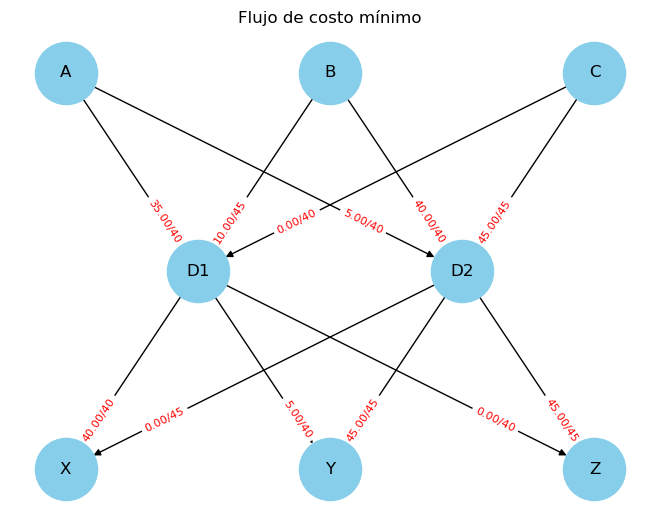

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir nodos al grafo
for nodo in nodos:
    G.add_node(nodo)

# Añadir arcos al grafo con sus capacidades y flujos
for i, j in arcos:
    G.add_edge(i, j, capacity=capacidades[(i,j)], flow=x[i,j].x)

# Posiciones fijas para los nodos
posiciones_fijas = {
    'A': (0, 2),
    'B': (1, 2),
    'C': (2, 2),
    'D1': (0.5, 1),
    'D2': (1.5, 1),
    'X': (0, 0),
    'Y': (1, 0),
    'Z': (2, 0)
}

# Dibujar el grafo con posiciones fijas
nx.draw(G, pos=posiciones_fijas, with_labels=True, node_size=2000, node_color="skyblue")

# Etiquetas de arcos con flujos y capacidades
edge_labels = {(i, j): f'{G[i][j]["flow"]:.2f}/{G[i][j]["capacity"]}' for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos=posiciones_fijas, edge_labels=edge_labels, font_size=8, label_pos=0.25, font_color="red")

plt.title("Flujo de costo mínimo")
plt.show()



### Problema de Transporte

El problema de transporte es un problema de programación lineal que busca determinar el plan de transporte de menor costo desde varios puntos de origen a varios puntos de destino, respetando las capacidades de oferta y demanda de cada punto.

#### Formulación Matemática:

**Conjuntos:**

- $i \in O$: Conjunto de puntos de origen.
- $j \in D$: Conjunto de puntos de destino.

**Parámetros:**

- $c_{ij}$: Costo de transportar una unidad desde el origen $i$ hasta el destino $j$.
- $s_i$: Cantidad de oferta en el origen $i$.
- $d_j$: Cantidad de demanda en el destino $j$.

**Variables de decisión:**

- $x_{ij}$: Cantidad a ser transportada desde el origen $i$ hasta el destino $j$.

**Función Objetivo:**

Minimizar $\sum_{i \in O} \sum_{j \in D} c_{ij} x_{ij}$

**Restricciones:**

1. Restricciones de oferta: 

   $\sum_{j \in D} x_{ij} = s_i \quad \forall i \in O$

2. Restricciones de demanda: 

   $\sum_{i \in O} x_{ij} = d_j \quad \forall j \in D$

3. Restricciones de no negatividad:

   $x_{ij} \geq 0$



#### Ejemplo ilustrativo

**Problema:**

Tienes 2 fábricas (A y B) y 3 tiendas (1, 2, 3). Deseas minimizar el costo de transporte entre las fábricas y las tiendas.

Datos:
- Costos:
  - A a 1: \$5
  - A a 2: \$4
  - A a 3: \$3
  - B a 1: \$2
  - B a 2: \$3
  - B a 3: \$1
- Oferta:
  - A: 10 unidades
  - B: 8 unidades
- Demanda:
  - 1: 5 unidades
  - 2: 7 unidades
  - 3: 6 unidades


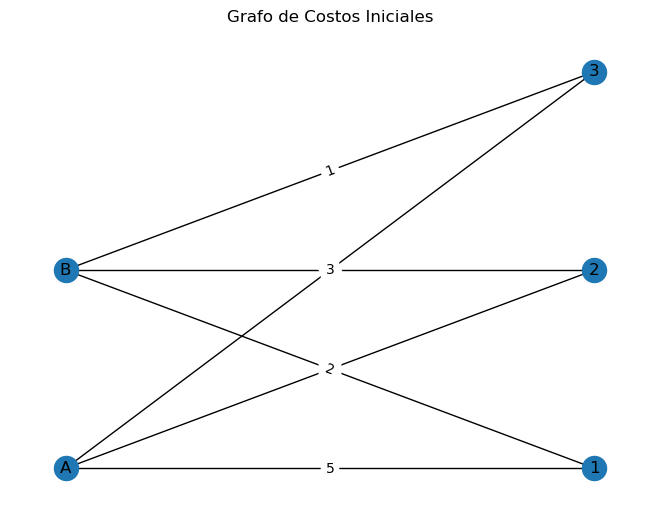

In [15]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

# Datos
origenes = ['A', 'B']
destinos = ['1', '2', '3']
oferta = {'A': 10, 'B': 8}
demanda = {'1': 5, '2': 7, '3': 6}
costos = {
    ('A', '1'): 5,
    ('A', '2'): 4,
    ('A', '3'): 3,
    ('B', '1'): 2,
    ('B', '2'): 3,
    ('B', '3'): 1
}

# Construcción del grafo bipartito
G = nx.Graph()
G.add_nodes_from(origenes, bipartite=0)
G.add_nodes_from(destinos, bipartite=1)
for (o, d), c in costos.items():
    G.add_edge(o, d, weight=c)

# Dibujo del grafo bipartito
pos = {}
pos.update((o, (1, i)) for i, o in enumerate(origenes))
pos.update((d, (2, i)) for i, d in enumerate(destinos))
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Grafo de Costos Iniciales")
plt.show()

In [ ]:

# Modelo de optimización
m = gp.Model('ProblemaTransporte')
x = m.addVars(origenes, destinos, name="x")
m.setObjective(gp.quicksum(costos[o, d]*x[o, d] for o in origenes for d in destinos), GRB.MINIMIZE)
m.addConstrs((gp.quicksum(x[o, d] for d in destinos) == oferta[o] for o in origenes), "Oferta")
m.addConstrs((gp.quicksum(x[o, d] for o in origenes) == demanda[d] for d in destinos), "Demanda")

m.optimize()

# Resultados
for o in origenes:
    for d in destinos:
        print(f"Transportar desde {o} a {d}: {x[o, d].x} unidades")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xf1c9c029
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+01]
Presolve removed 4 rows and 3 columns
Presolve time: 0.01s
Presolved: 1 rows, 3 columns, 3 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7000000e+01   5.000000e+00   0.000000e+00      0s
       1    5.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.000000000e+01
Transportar desde A a 1: 0.0 unidades
Transportar desde A a 2: 7.0 unidades
Transportar desde A a 3: 3.0 unidades
Transportar desde B 

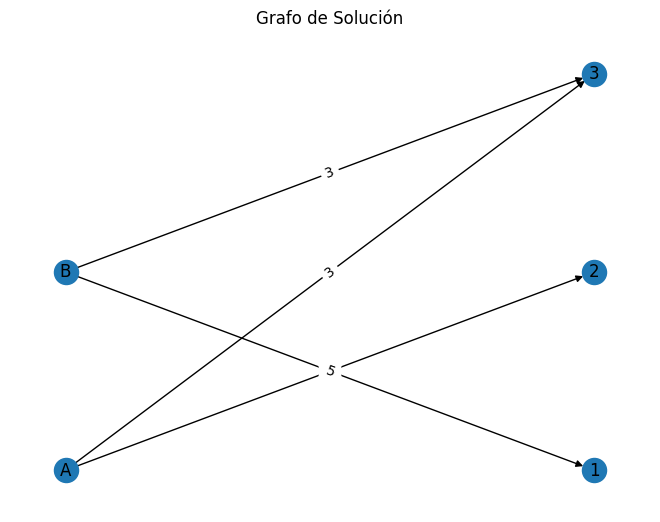

In [ ]:
# Creación del grafo de solución
G_solution = nx.DiGraph()
for o in origenes:
    for d in destinos:
        if x[o, d].x > 0:
            G_solution.add_edge(o, d, weight=round(x[o, d].x))
            
# Dibujo del grafo bipartito de solución
pos_solution = {}
pos_solution.update((o, (1, i)) for i, o in enumerate(origenes))
pos_solution.update((d, (2, i)) for i, d in enumerate(destinos))
nx.draw(G_solution, pos_solution, with_labels=True)
labels_solution = nx.get_edge_attributes(G_solution, 'weight')
nx.draw_networkx_edge_labels(G_solution, pos_solution, edge_labels=labels_solution)
plt.title("Grafo de Solución")
plt.show()

### Ejemplo 2:

Supongamos que una empresa de transporte tiene bodegas en tres ciudades $(A, B y C)$ y necesita enviar productos a tiendas en otras tres ciudades $(X, Y y Z)$. Las bodegas tienen una cierta cantidad de productos y las tiendas tienen una demanda específica. Además, el costo de enviar una unidad de producto de una ciudad a otra es conocido. El objetivo es determinar la cantidad de productos que deben ser enviados desde cada bodega a cada tienda de manera que se minimice el costo total de transporte y se satisfaga la demanda de cada tienda.

- Oferta en bodegas:
  - A: 20
  - B: 30
  - C: 25
  
- Demanda en tiendas:
  - X: 10
  - Y: 25
  - Z: 40
  
- Costo de transporte (por unidad de producto):

  |    | X | Y | Z |
  |----|---|---|---|
  | A  | 8 | 6 | 10|
  | B  | 9 | 5 | 9 |
  | C  | 11| 7 | 7 |

### Formulación Matemática:

- Conjuntos:
  - $I$: Conjunto de bodegas, $I = \{A, B, C\}$.
  - $J$: Conjunto de tiendas, $J = \{X, Y, Z\}$.

- Parámetros:
  - $ s_i $: Oferta de la bodega $i \in I$.
  - $ d_j $: Demanda de la tienda $j \in J$.
  - $ c_{ij} $: Costo de enviar una unidad de producto de la bodega $i$ a la tienda $j$.

- Variables:
  - $ x_{ij} $: Cantidad de productos enviados de la bodega $i$ a la tienda $j$.

**Función objetivo**:

Minimizar $ \sum_{i \in I} \sum_{j \in J} c_{ij} x_{ij} $

**Restricciones**:

1. Oferta en bodegas:
$$ \sum_{j \in J} x_{ij} = s_i \quad \forall i \in I $$

2. Demanda en tiendas:
$$ \sum_{i \in I} x_{ij} = d_j \quad \forall j \in J $$

3. No negatividad:
$$ x_{ij} \geq 0 \quad \forall i \in I, \forall j \in J $$


**Código en Python:**

In [ ]:
from gurobipy import Model, GRB
import networkx as nx
import matplotlib.pyplot as plt

# Data
bodegas = ['A', 'B', 'C']
tiendas = ['X', 'Y', 'Z']
oferta = {'A': 20, 'B': 30, 'C': 25}
demanda = {'X': 10, 'Y': 25, 'Z': 40}
costos = {
    ('A', 'X'): 8, ('A', 'Y'): 6, ('A', 'Z'): 10,
    ('B', 'X'): 9, ('B', 'Y'): 5, ('B', 'Z'): 9,
    ('C', 'X'): 11, ('C', 'Y'): 7, ('C', 'Z'): 7
}

# Creación del grafo
G = nx.DiGraph()

# Adición de nodos
for bodega in bodegas:
    G.add_node(bodega, demand=-oferta[bodega])  # Las bodegas tienen oferta negativa (porque suministran)

for tienda in tiendas:
    G.add_node(tienda, demand=demanda[tienda])

# Adición de aristas con costos
for (bodega, tienda), costo in costos.items():
    G.add_edge(bodega, tienda, weight=costo)

# Dibujo del grafo
pos = {
    'A': (0, 1),
    'B': (0, 0),
    'C': (0, -1),
    'X': (1, 1),
    'Y': (1, 0),
    'Z': (1, -1)
}
edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges()}

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=20, edge_color='gray', width=2, alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)
plt.title("Red Inicial de Transporte")
plt.show()


In [ ]:
# Modelo
m = Model("Flujo de costo mínimo")

# Variables
x = m.addVars(bodegas, tiendas, name="x")

# Función objetivo
m.setObjective(x.prod(costos), GRB.MINIMIZE)

# Restricciones
for i in bodegas:
    m.addConstr(sum(x[i,j] for j in tiendas) == oferta[i], name=f"Oferta_{i}")

for j in tiendas:
    m.addConstr(sum(x[i,j] for i in bodegas) == demanda[j], name=f"Demanda_{j}")

# Resolver
m.optimize()

In [ ]:
# Resultados
for i, j in x:
    print(f"Enviar {x[i,j].x} unidades de bodega {i} a tienda {j}")
    


In [ ]:
# Creación del grafo basado en la solución
G_sol = nx.DiGraph()

for i, j in x:
    cantidad = x[i, j].x
    if cantidad > 0:
        G_sol.add_edge(i, j, weight=cantidad)

# Dibujo del grafo
pos = {
    'A': (0, 1),
    'B': (0, 0),
    'C': (0, -1),
    'X': (1, 1),
    'Y': (1, 0),
    'Z': (1, -1)
}
edge_labels = {(i, j): G_sol[i][j]['weight'] for i, j in G_sol.edges()}

nx.draw(G_sol, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=20, edge_color='gray', width=2, alpha=0.6)
nx.draw_networkx_edge_labels(G_sol, pos, edge_labels=edge_labels, font_size=15)
plt.title("Red Óptima de Transporte")
plt.show()

### Problema de Circulación (Circulation Problem)

El problema de circulación es una generalización del problema de flujo en redes. En este problema, en lugar de tener un único punto de origen y un único punto de destino, se pueden tener múltiples puntos con requerimientos de flujo, tanto entrantes como salientes. El objetivo es determinar si existe un flujo factible que satisfaga todos estos requerimientos.

**Aplicaciones en Ingeniería**:

1. **Sistemas de Distribución de Agua**: El problema de circulación puede ayudar a modelar y optimizar la distribución de agua en una ciudad o región, teniendo en cuenta las demandas y ofertas en diferentes puntos.
   
2. **Redes de Telecomunicaciones**: Puede utilizarse para determinar la factibilidad de transmitir datos entre diferentes nodos de una red, teniendo en cuenta las capacidades y las demandas.

3. **Optimización de Tráfico Urbano**: Ayuda en la planificación y optimización del flujo vehicular en una ciudad, asegurando que las demandas y capacidades de diferentes intersecciones y carreteras sean satisfechas.

**Formulación**:

Dada una red $ G = (N, A) $ donde $ N $ es el conjunto de nodos y $ A $ es el conjunto de arcos. Cada arco $ (i,j) $ tiene una capacidad $ u_{ij} $ y cada nodo $ i $ tiene un requerimiento de flujo $ b_i $ (donde $ b_i > 0 $ significa que el nodo tiene una oferta y $ b_i < 0 $ significa que el nodo tiene una demanda).

**Variables de decisión**:
- $ x_{ij} $: flujo en el arco $ (i, j) $.

**Modelo Matemático**:

1. **Función Objetivo**: En el problema básico de circulación, no hay una función objetivo per se, ya que simplemente estamos buscando la factibilidad. Sin embargo, se pueden tener variaciones con objetivos específicos.

2. **Restricciones**:
   - Balance de flujo en cada nodo:
     
     $\sum_{j:(i,j) \in A} x_{ij} - \sum_{j:(j,i) \in A} x_{ji} = b_i \quad \forall i \in N$
     
   - Capacidades de los arcos:
   
     $0 \leq x_{ij} \leq u_{ij} \quad \forall (i,j) \in A$


![](../Images/circulation1.png)

![](../Images/circulation2.png)

### Multicommodity Flow Problem (MFP)

El problema de flujo multicomedidad (MFP, por sus siglas en inglés) es una generalización del problema de flujo máximo en redes. Mientras que en el problema de flujo máximo se busca enviar la máxima cantidad de una única mercancía entre un punto de origen y un punto de destino, en el MFP se intenta enviar varias mercancías diferentes entre diversos puntos de origen y destino respetando las capacidades de los arcos y otros posibles restricciones.

#### Ejemplos de aplicación en problemas de ingeniería:
1. **Diseño de Redes de Telecomunicaciones**: Donde diferentes datos o señales (commodities) necesitan ser transmitidos entre varios nodos.
2. **Planificación de Transporte**: Optimizar la distribución de diferentes productos entre ciudades utilizando una red de carreteras.
3. **Planificación de la Distribución de Energía**: Como enviar diferentes tipos de energía (electricidad, gas) a diferentes ciudades o zonas.
4. **Logística y Cadena de Suministro**: En donde diferentes productos necesitan ser distribuidos desde múltiples fábricas a múltiples almacenes o clientes.

#### Formulación matemática

Sea $ G = (V,E) $ una red dirigida, donde $ V $ es el conjunto de vértices y $ E $ el conjunto de arcos. Considera $ K $ como el conjunto de commodities. Para cada commodity $ k $ en $ K $, tenemos un nodo origen $ s_k $, un nodo destino $ t_k $ y una demanda $ d_k $. Cada arco $ (i,j) $ tiene una capacidad $ u_{ij} $.

Las variables de decisión son:
$ x_{ij}^k $ : Cantidad de flujo del commodity $ k $ que pasa por el arco $ (i,j) $.

El objetivo es maximizar el flujo total o cumplir con las demandas dadas.

Formulación:

1. **Función objetivo**:
$ \max \sum_{k \in K} \sum_{(i,j) \in E} x_{ij}^k $

2. **Restricciones**:

   a) Conservación del flujo para cada nodo:
   $$ \sum_{j:(i,j) \in E} x_{ij}^k - \sum_{j:(j,i) \in E} x_{ji}^k = 
   \begin{cases} 
   d_k & \text{si } i = s_k \\
   -d_k & \text{si } i = t_k \\
   0 & \text{en otro caso}
   \end{cases}
   $$
   para todo $ k \in K $ y para todo $ i \in V $.

   b) Capacidad de los arcos:
   $$ \sum_{k \in K} x_{ij}^k \leq u_{ij} $$
   para todo $ (i,j) \in E $.



#### Ejemplo ilustrativo:

Dos productos ('Lápices' y 'Pens') se producen en 2 ciudades ('Detroit' y 'Denver') y deben enviarse a almacenes en 3 ciudades ('Boston', 'Nueva York' y 'Seattle') a satisfacer la oferta/demanda. Los flujos en la red de transporte deben respetar las restricciones de capacidad del arco ('capacidad[i,j]'). El objetivo es minimizar la suma de los costos de transporte del arco.

**Conjuntos:**
- $ C $: conjunto de productos o commodities.
- $ N $: conjunto de nodos o ciudades.
- $ A $: conjunto de arcos entre ciudades.

**Parámetros:**
- $ \text{cost}_{hij} $: costo de transportar el producto $ h $ desde la ciudad $ i $ a la ciudad $ j $.
- $ \text{capacity}_{ij} $: capacidad máxima del arco entre las ciudades $ i $ y $ j $.
- $ \text{inflow}_{hi} $: oferta (si es positiva) o demanda (si es negativa) del producto $ h $ en la ciudad $ i $.

**Variables de decisión:**
- $ \text{flow}_{hij} $: cantidad del producto $ h $ que se envía desde la ciudad $ i $ a la ciudad $ j $.


**Minimizar:**
$$ 
\sum_{h \in C} \sum_{(i,j) \in A} \text{cost}_{hij} \times \text{flow}_{hij} 
$$

**Sujeto a:**

1) **Restricciones de capacidad en los arcos:**
$$ 
\sum_{h \in C} \text{flow}_{hij} \leq \text{capacity}_{ij} \quad \forall (i,j) \in A
$$

2) **Restricciones de conservación del flujo (balance de oferta y demanda):**
$$ 
\sum_{j:(i,j) \in A} \text{flow}_{hij} - \sum_{j:(j,i) \in A} \text{flow}_{hji} = \text{inflow}_{hi} \quad \forall h \in C, \forall i \in N
$$

3) **Restricciones de no negatividad:**
$$ 
\text{flow}_{hij} \geq 0 \quad \forall h \in C, \forall (i,j) \in A
$$





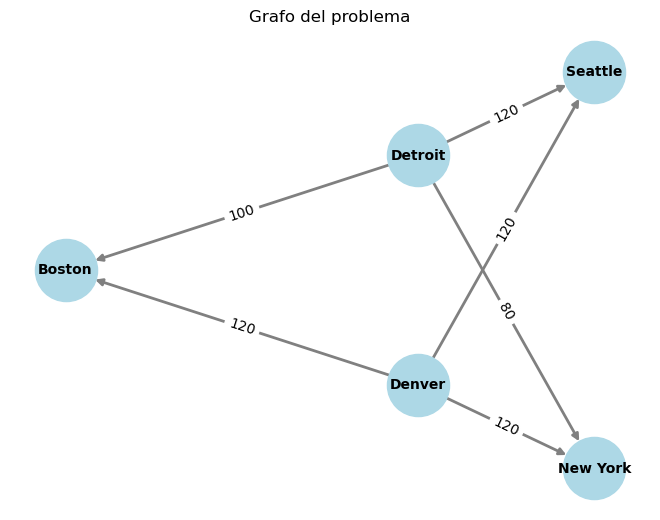

In [ ]:
import gurobipy as gp
from gurobipy import GRB


# Base data
commodities = ['Pencils', 'Pens']
nodes = ['Detroit', 'Denver', 'Boston', 'New York', 'Seattle']

arcs, capacity = gp.multidict({
    ('Detroit', 'Boston'):   100,
    ('Detroit', 'New York'):  80,
    ('Detroit', 'Seattle'):  120,
    ('Denver',  'Boston'):   120,
    ('Denver',  'New York'): 120,
    ('Denver',  'Seattle'):  120})

cost = {
    ('Pencils', 'Detroit', 'Boston'):   10,
    ('Pencils', 'Detroit', 'New York'): 20,
    ('Pencils', 'Detroit', 'Seattle'):  60,
    ('Pencils', 'Denver',  'Boston'):   40,
    ('Pencils', 'Denver',  'New York'): 40,
    ('Pencils', 'Denver',  'Seattle'):  30,
    ('Pens',    'Detroit', 'Boston'):   20,
    ('Pens',    'Detroit', 'New York'): 20,
    ('Pens',    'Detroit', 'Seattle'):  80,
    ('Pens',    'Denver',  'Boston'):   60,
    ('Pens',    'Denver',  'New York'): 70,
    ('Pens',    'Denver',  'Seattle'):  30}

# Supply (> 0) and demand (< 0) for pairs of commodity-city
inflow = {
    ('Pencils', 'Detroit'):   50,
    ('Pencils', 'Denver'):    60,
    ('Pencils', 'Boston'):   -50,
    ('Pencils', 'New York'): -50,
    ('Pencils', 'Seattle'):  -10,
    ('Pens',    'Detroit'):   60,
    ('Pens',    'Denver'):    40,
    ('Pens',    'Boston'):   -40,
    ('Pens',    'New York'): -30,
    ('Pens',    'Seattle'):  -30}

# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir nodos
for node in nodes:
    G.add_node(node)

# Añadir aristas con sus capacidades como etiquetas
for (i, j), cap in capacity.items():
    G.add_edge(i, j, capacity=cap)

# Usar el diseño en capas concéntricas
shell_layout_layers = [['Detroit', 'Denver'], ['Boston', 'New York', 'Seattle']]
pos = nx.shell_layout(G, shell_layout_layers)

labels = nx.get_edge_attributes(G, 'capacity')
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight='bold', width=2, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Grafo del problema")
plt.show()



In [ ]:

# Create optimization model
m = gp.Model('netflow')

# Create variables
flow = m.addVars(commodities, arcs, obj=cost, name="flow")

# Arc-capacity constraints
m.addConstrs(
    (flow.sum('*', i, j) <= capacity[i, j] for i, j in arcs), "cap")

# Flow-conservation constraints
m.addConstrs(
    (flow.sum(h, '*', j) + inflow[h, j] == flow.sum(h, j, '*')
        for h in commodities for j in nodes), "node")

# Compute optimal solution
m.optimize()

# Print solution
if m.Status == GRB.OPTIMAL:
    solution = m.getAttr('X', flow)
    for h in commodities:
        print('\nOptimal flows for %s:' % h)
        for i, j in arcs:
            if solution[h, i, j] > 0:
                print('%s -> %s: %g' % (i, j, solution[h, i, j]))


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16 rows, 12 columns and 36 nonzeros
Model fingerprint: 0xc43e5943
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+02]
Presolve removed 16 rows and 12 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5000000e+03   0.000000e+00   2.000000e+01      0s
Extra simplex iterations after uncrush: 1
       1    5.5000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.500000000e+03

Optimal flows for Pencils:
Detroit -> Boston: 50
Denver -> New York: 50
Denver -> Seattle: 10

Optimal fl

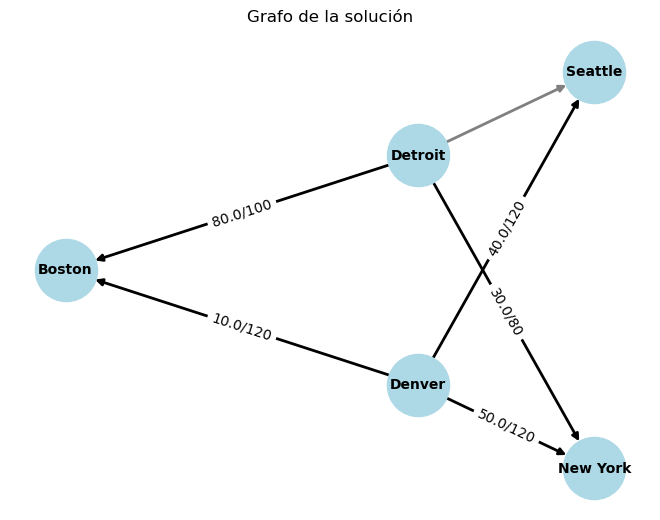

In [ ]:
# Si m.Status es óptimo, añadir el flujo de la solución al grafo y dibujarlo nuevamente
if m.Status == GRB.OPTIMAL:
    solution = m.getAttr('X', flow)
    edge_colors = []
    labels = {}
    for i, j in arcs:
        total_flow = sum(solution[h, i, j] for h in commodities)
        if total_flow > 0:
            G[i][j]['flow'] = total_flow
            labels[(i, j)] = f"{total_flow}/{G[i][j]['capacity']}"
            edge_colors.append('black')  # color negro para las aristas con flujo
        else:
            edge_colors.append('gray')  # color gris para las aristas sin flujo
    
    # Dibujar el grafo de la solución
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight='bold', edge_color=edge_colors, width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    plt.title("Grafo de la solución")
    plt.show()

## Ejemplos de aplicación



### Modelaje Knaspack

Una empresa tiene disponibles 34 millones de pesos y está considerando los siguientes 5 proyectos de inversion 

| Proyecto | Inversión en millones| Beneficio VPN en millones |
|----------|-----------|-----------|
| 1        | 6        | 9         |
| 2        | 4         | 5         |
| 3        | 13         | 20         |
| 4        | 7        | 11         |
| 5        | 11         | 17         |

El objetivo es determinar la combinación de proyectos que maximice el beneficio total, respetando la restricción de presupuesto.



**Estrategia de solución**

Calcular razón VPN/Costo por proyecto y seleccionar los proyectos de mayor razón hasta que se agote el presupuesto.

Tabla de razones:
| Proyecto | Razón VPN/Costo |
|----------|-----------|
| 1        | 1.5        |
| 2        | 1.25         |
| 3        | 1.54         |
| 4        | 1.57        |
| 5        | 1.54         |

Flujo en el tiempo: 31 millones de pesos
VPN: 48 millones de pesos


**Knaspack como la ruta más corta**

![knaspack](../Images/KP1.png)



![knaspack](../Images/KP2.png)



![knaspack](../Images/KP3.png)



![knaspack](../Images/KP4.png)



![knaspack](../Images/KP5.png)



![knaspack](../Images/KP6.png)



![knaspack](../Images/KP7.png)

### Modelaje divorcio

En un proceso de conciliación de un  divorcio Juana y Martín han expresado sus preferencias por los bienes (j=1,2,3,4,5) que hicieron durante su matrimonio. Esta preferencia se encuentra en una escala de 0 a 10. Adicionalmente, el conciliador sabe que a lo sumo pueden asignar 3 bienes a juana o martin, pero deben asignar la totalidad de bienes para los dos. El conciliador desea encontrar una asignación de bienes que maximize la satisfacción total de la antigua pareja:


 | Bien | Martin| Juana |
|----------|-----------|-----------|
| 1        | 8       | 7         |
| 2        | 5         | 8        |
| 3        | 9         | 6         |
| 4        | 8        | 8         |
| 5        | 7        | 9         |

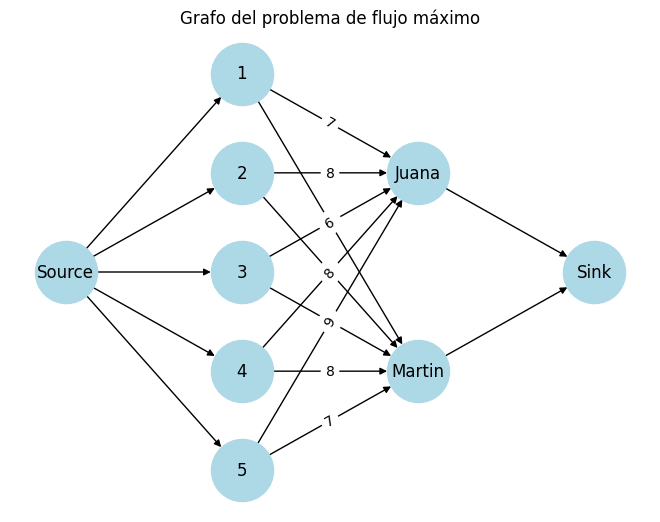

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Datos del problema
bienes = list(range(1, 6))
personas = ['Juana', 'Martin']

costos = {
    (1, 'Martin'): 8,
    (1, 'Juana'): 7,
    (2, 'Martin'): 5,
    (2, 'Juana'): 8,
    (3, 'Martin'): 9,
    (3, 'Juana'): 6,
    (4, 'Martin'): 8,
    (4, 'Juana'): 8,
    (5, 'Martin'): 7,
    (5, 'Juana'): 9
}

# Crear el grafo
G = nx.DiGraph()

# Agregar nodos
G.add_nodes_from(bienes)
G.add_nodes_from(personas)
G.add_node('Source')
G.add_node('Sink')

# Agregar aristas
for i in bienes:
    G.add_edge('Source', i)
    for j in personas:
        G.add_edge(i, j, weight=costos[i, j])
        G.add_edge(j, 'Sink')

# Dibujar el grafo con un layout personalizado
pos = {
    'Source': (0, 3),
    1: (1, 5),
    2: (1, 4),
    3: (1, 3),
    4: (1, 2),
    5: (1, 1),
    'Juana': (2, 4),
    'Martin': (2, 2),
    'Sink': (3, 3)
}

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Grafo del problema de flujo máximo")
plt.show()


In [ ]:
from gurobipy import Model, GRB

# Datos del problema
bienes = list(range(1, 6))
personas = ['Juana', 'Martin']

costos = {
    (1, 'Martin'): 8,
    (1, 'Juana'): 7,
    (2, 'Martin'): 5,
    (2, 'Juana'): 8,
    (3, 'Martin'): 9,
    (3, 'Juana'): 6,
    (4, 'Martin'): 8,
    (4, 'Juana'): 8,
    (5, 'Martin'): 7,
    (5, 'Juana'): 9
}

# Crear modelo
m = Model("divorcio")

# Variables de decisión
x = m.addVars(bienes, personas, vtype=GRB.BINARY, name="x")

# Función objetivo
m.setObjective(sum(costos[i, j] * x[i, j] for i in bienes for j in personas), GRB.MAXIMIZE)

# Restricciones

# Todos los bienes deben ser asignados
for i in bienes:
    m.addConstr(sum(x[i, j] for j in personas) == 1, f"bien_{i}_asignado")

# A Juana y a Martin se les puede asignar a lo sumo 3 bienes
for j in personas:
    m.addConstr(sum(x[i, j] for i in bienes) <= 3, f"max_3_bienes_{j}")

# El flujo total de la fuente hacia los bienes es 5
m.addConstr(sum(x[i, 'Juana'] + x[i, 'Martin'] for i in bienes) == 5, "total_bienes")

# Conservación de flujo
for i in bienes:
    m.addConstr(x[i, 'Juana'] + x[i, 'Martin'] == 1, f"flujo_bien_{i}")

# Resolver modelo
m.optimize()

# Mostrar resultados
if m.status == GRB.OPTIMAL:
    for i in bienes:
        for j in personas:
            if x[i, j].x > 0.5:
                print(f"El bien {i} se asigna a {j}")
else:
    print("No se encontró una solución óptima.")


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13 rows, 10 columns and 40 nonzeros
Model fingerprint: 0xa3714c56
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 10 nonzeros
Variable types: 0 continuous, 5 integer (5 binary)
Found heuristic solution: objective 42.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 42 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.200000000000e+01, best bound 4.200000000000e+01, gap 0.0000


**Variables de Decisión**:
$$ x_{ij} $$
Donde:
- $ i $ es un nodo origen.
- $ j $ es un nodo destino.

$ x_{ij} = 1 $ si el flujo pasa de $ i $ a $ j $, y $ x_{ij} = 0 $ si no.

**Función Objetivo**:
Maximizar la satisfacción total:
$$ \max Z = \sum_{i \in \text{bienes}, j \in \{\text{Juana, Martin}\}} c_{ij} \times x_{ij} $$
Donde:
- $ c_{ij} $ es el costo (satisfacción) de asignar el bien $ i $ a la persona $ j $.

**Restricciones**:

1. Cada bien debe ser asignado exactamente una vez:
$$ \sum_{j \in \{\text{Juana, Martin}\}} x_{ij} = 1 \quad \forall i \in \text{bienes} $$

2. A Juana y a Martin se les puede asignar a lo sumo 3 bienes:
$$ \sum_{i \in \text{bienes}} x_{i\text{Juana}} \leq 3 $$
$$ \sum_{i \in \text{bienes}} x_{i\text{Martin}} \leq 3 $$

3. Flujos binarios:
$$ x_{ij} \in \{0,1\} \quad \forall i, j $$

Con esta formulación, se busca maximizar la satisfacción total de asignación de bienes entre Juana y Martin sujeto a las restricciones de que cada bien solo puede ser asignado una vez y que no se pueden asignar más de 3 bienes a cada persona.

In [ ]:
from gurobipy import Model, GRB

# Datos del problema
bienes = list(range(1, 6))
personas = ['Juana', 'Martin']

costos = {
    (1, 'Martin'): 8,
    (1, 'Juana'): 7,
    (2, 'Martin'): 5,
    (2, 'Juana'): 8,
    (3, 'Martin'): 9,
    (3, 'Juana'): 6,
    (4, 'Martin'): 8,
    (4, 'Juana'): 8,
    (5, 'Martin'): 7,
    (5, 'Juana'): 9
}

# Crear modelo
m = Model("divorcio")

# Variables de decisión
x = m.addVars(bienes, personas,  name="x")

# Función objetivo
m.setObjective(sum(costos[i, j] * x[i, j] for i in bienes for j in personas), GRB.MAXIMIZE)

# Restricciones
for i in bienes:
    m.addConstr(sum(x[i, j] for j in personas) == 1, f"bien_{i}_asignado")

for j in personas:
    m.addConstr(sum(x[i, j] for i in bienes) <= 3, f"max_3_bienes_{j}")

# Resolver modelo
m.optimize()

# Mostrar resultados
if m.status == GRB.OPTIMAL:
    for i in bienes:
        for j in personas:
            if x[i, j].x > 0.5:
                print(f"El bien {i} se asigna a {j}")
else:
    print("No se encontró una solución óptima.")



Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 10 columns and 20 nonzeros
Model fingerprint: 0xf6717dd4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 7 rows and 10 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  4.200000000e+01
El bien 1 se asigna a Martin
El bien 2 se asigna a Juana
El bien 3 se asigna a Martin
El bien 4 se asigna a Juana
El bien 5 se asigna a Juana


### Inventario

en una ronda de negocios en cartagena, zapatos andinos ha suscrito un contrato enmaarcado en el ATPA que lo obliga a satisfacer a tiempo las siguiente demandas de zapatos para los proximos meses: mes 1, 1000 pares, mes 2, 1500 pares y mes 3 , 1800 pares. Toma 1 hora de trabajo producir un par de zapatos. Durante los proximos tres meses, el numero de horas disponibles en horario regular son : para el mes 1, 1000 horas; para el mes 2, 1200 horas y para el mes 3, 1200 horas. Para cada mes la compañia  puede obtener tambien 400 horas extras adicionales. A los trabajadores se les paga por hora trabajads. El pago es de \$4 por hora regular y $6 por hora extra. Al final del mes, se incurre en un costo de \$ 1.5 por cada par de zapatos en inventario. Modele el problema como una red y diga que algoritmo utilizaria para resovlerlo. Defina claramente el grafo, los costos,las cotas inferiores y superiores y demás. 

![inventario](../Images/inventario.png)

**Formulación matemática**


**Variables de decisión**:
- $ x_{i}^{R} $: Cantidad de zapatos producidos en el mes $ i $ en horario regular.
- $ x_{i}^{E} $: Cantidad de zapatos producidos en el mes $ i $ en horario extra.
- $ s_{i} $: Cantidad de zapatos almacenados al final del mes $ i $.

El objetivo es minimizar los costos totales que incluyen la producción y el almacenamiento.

**Función objetivo**:
$$ \min \sum_{i=1}^{3} (4 \times x_{i}^{R} + 6 \times x_{i}^{E} + 1.5 \times s_{i}) $$

**Restricciones**:

1. **Capacidad de producción regular**:
$$ x_{1}^{R} \leq 1000 $$
$$ x_{2}^{R} \leq 1200 $$
$$ x_{3}^{R} \leq 1200 $$

2. **Capacidad de producción extra**:
$$ x_{1}^{E} \leq 400 $$
$$ x_{2}^{E} \leq 400 $$
$$ x_{3}^{E} \leq 400 $$

3. **Balance de inventario y demanda**:
$$ x_{1}^{R} + x_{1}^{E} = 1000 + s_{1} $$
$$ x_{2}^{R} + x_{2}^{E} + s_{1} = 1500 + s_{2} $$
$$ x_{3}^{R} + x_{3}^{E} + s_{2} = 1800 + s_{3} $$

4. **No almacenamiento al final del último mes**:
$$ s_{3} = 0 $$

5. **No negatividad**:
$$ x_{i}^{R}, x_{i}^{E}, s_{i} \geq 0 \quad \forall i $$

La función objetivo busca minimizar los costos de producción y almacenamiento. Las restricciones aseguran que no se superen las capacidades de producción y que la demanda de cada mes sea satisfecha teniendo en cuenta el inventario del mes anterior. El almacenamiento al final del último mes es cero para asegurar que no haya costos innecesarios de inventario después de satisfacer toda la demanda.

In [ ]:
from gurobipy import *

# Datos
horas_por_mes_regular = [1000, 1200, 1200]
horas_por_mes_extra = [400, 400, 400]
costo_hora_regular = 4
costo_hora_extra = 6
costo_inventario = 1.5
demanda_por_mes = [1000, 1500, 1800]

m = Model("ZapatosAndinos")

# Variables para la producción (regular y extra) para cada mes
prod_regular = m.addVars(3, name="ProdReg")
prod_extra = m.addVars(3, name="ProdExt")

# Variables para el inventario al final de cada mes
inventario = m.addVars(4, name="Inventario", lb=0)

# Restricciones de capacidad de producción
m.addConstrs((prod_regular[i] <= horas_por_mes_regular[i] for i in range(3)), name="CapacidadRegular")
m.addConstrs((prod_extra[i] <= horas_por_mes_extra[i] for i in range(3)), name="CapacidadExtra")

# Restricciones de balance entre producción, inventario y demanda
m.addConstr(inventario[0] == 0)  # No hay inventario al inicio
for i in range(3):
    m.addConstr(inventario[i] + prod_regular[i] + prod_extra[i] - inventario[i+1] == demanda_por_mes[i], name=f"BalanceMes_{i+1}")

m.setObjective(
    sum(costo_hora_regular * prod_regular[i] for i in range(3)) +
    sum(costo_hora_extra * prod_extra[i] for i in range(3)) +
    sum(costo_inventario * inventario[i] for i in range(1, 4)),
    GRB.MINIMIZE
)

m.optimize()

if m.status == GRB.Status.OPTIMAL:
    print("\nSolución óptima encontrada:")
    for v in m.getVars():
        print(f"{v.varName}: {v.x}")
    print(f"Costo total: ${m.objVal}")
else:
    print("No se encontró una solución óptima.")


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 10 columns and 19 nonzeros
Model fingerprint: 0xd2712f68
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 2e+03]
Presolve removed 10 rows and 10 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9450000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.945000000e+04

Solución óptima encontrada:
ProdReg[0]: 1000.0
ProdReg[1]: 1200.0
ProdReg[2]: 1200.0
ProdExt[0]: 100.0
ProdExt[1]: 400.0
ProdExt[2]: 400.0
Inventario[0]: 0.0
Inventario[1]: 100.0
Inventario[2]: 20

### Ejercicio

![ejercicio](../Images/exer_model.png)